<a href="https://colab.research.google.com/github/ranjan2829/Quant/blob/main/Quant_%26_Algorithmic_trading_strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Unsupervised Learning on s&p 500 stocks


In [2]:
pip install pandas_ta


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=c1e497879406df681ea171672cb34ed5fb5b7971a1b33c33cd4cfbf61d879d4c
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [48]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2023-09-27'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%%**********************]  503 of 503 completed

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['VLTO']: Exception("%ticker%: Data doesn't exist for startDate = 1443499200, endDate = 1695787200")



[*********************102%%***********************]  513 of 503 completed

adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.534708   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361622   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.716064   27.264999   28.377501   26.965000   28.207500   
           ABBV     37.024632   52.790001   54.189999   51.880001   53.099998   
           ABT      33.807262   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 YUM     123.426186  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.992920  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZION     33.581326   33.990002   34.700001   33.840000   33.840000   
           ZTS     176.447540  176.869995  178.449997  176.270004  176.580002   

                        volume  
date       ticker               
2015-09-29 A         2252400.0  
           AAL       7478800.0  
           AAPL    293461600.0  
           ABBV     12842800.0  
           ABT      12287500.0  
...                        ...  
2023-09-26 YUM       1500600.0  
           ZBH       3610500.0  
           ZBRA       355400.0  
           ZION      1586100.0  
           ZTS       1463200.0  

[993179 rows x 6 columns]

In [49]:
df['garman_volatility'] = ((np.log(df['high']) - np.log(df['low']))**2) / 2 - (2 * np.log(2) - 1) * (np.log(df['close']) - np.log(df['open'])**2)


In [54]:
df

adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.534708   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361622   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.716064   27.264999   28.377501   26.965000   28.207500   
           ABBV     37.024632   52.790001   54.189999   51.880001   53.099998   
           ABT      33.807262   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 YUM     123.426186  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.992920  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZION     33.581326   33.990002   34.700001   33.840000   33.840000   
           ZTS     176.447540  176.869995  178.449997  176.270004  176.580002   

                        volume  garman_volatility  
date       ticker                                  
2015-09-29 A         2252400.0           3.393071  
           AAL       7478800.0           3.771667  
           AAPL    293461600.0           3.032649  
           ABBV     12842800.0           4.563807  
           ABT      12287500.0           3.783811  
...                        ...                ...  
2023-09-26 YUM       1500600.0           7.120771  
           ZBH       3610500.0           6.929784  
           ZBRA       355400.0           9.259367  
           ZION      1586100.0           3.429028  
           ZTS       1463200.0           8.341145  

[993179 rows x 7 columns]

In [56]:

df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

<Axes: xlabel='date'>

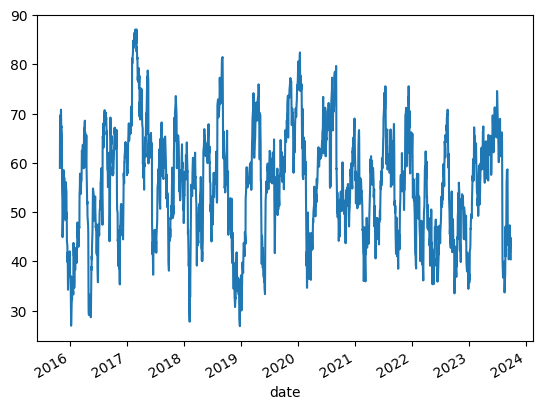

In [58]:
df.xs('AAPL',level=1)['rsi'].plot()

In [60]:
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])

df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])

df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])


<Axes: xlabel='date'>

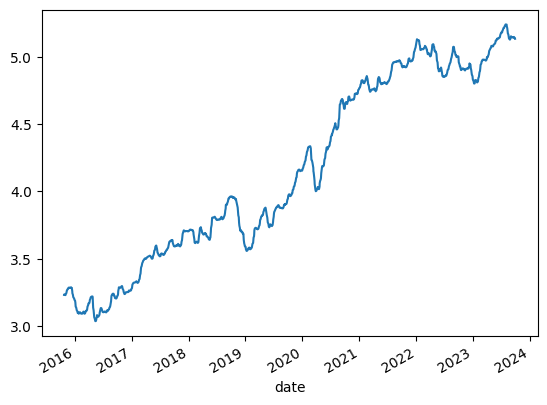

In [61]:
df.xs('AAPL',level=1)['bb_low'].plot()

<Axes: xlabel='date'>

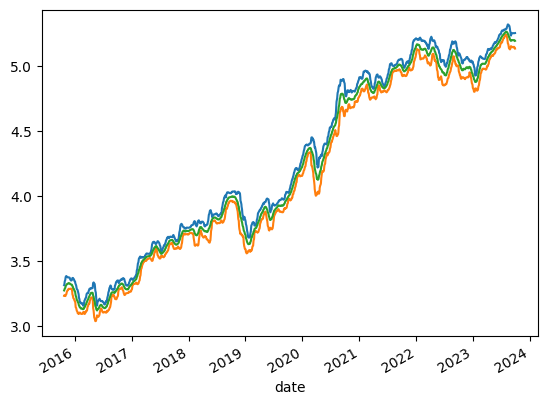

In [65]:
df.xs("AAPL",level=1)['bb_high'].plot()
df.xs('AAPL',level=1)['bb_low'].plot()
df.xs("AAPL",level=1)['bb_mid'].plot()

In [66]:
df

adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.534708   33.740002   34.060001   33.240002   33.360001   
           AAL      37.361622   39.180000   39.770000   38.790001   39.049999   
           AAPL     24.716064   27.264999   28.377501   26.965000   28.207500   
           ABBV     37.024632   52.790001   54.189999   51.880001   53.099998   
           ABT      33.807262   39.500000   40.150002   39.029999   39.259998   
...                       ...         ...         ...         ...         ...   
2023-09-26 YUM     123.426186  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.992920  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZION     33.581326   33.990002   34.700001   33.840000   33.840000   
           ZTS     176.447540  176.869995  178.449997  176.270004  176.580002   

                        volume  garman_volatility  garman_klass_vol  \
date       ticker                                                     
2015-09-29 A         2252400.0           3.393071         -0.000926   
           AAL       7478800.0           3.771667         -0.000443   
           AAPL    293461600.0           3.032649         -0.005441   
           ABBV     12842800.0           4.563807         -0.049280   
           ABT      12287500.0           3.783811         -0.008237   
...                        ...                ...               ...   
2023-09-26 YUM       1500600.0           7.120771          0.000037   
           ZBH       3610500.0           6.929784          0.000161   
           ZBRA       355400.0           9.259367          0.000133   
           ZION      1586100.0           3.429028          0.000292   
           ZTS       1463200.0           8.341145          0.000075   

                         rsi    bb_low    bb_mid   bb_high  
date       ticker                                           
2015-09-29 A             NaN       NaN       NaN       NaN  
           AAL           NaN       NaN       NaN       NaN  
           AAPL          NaN       NaN       NaN       NaN  
           ABBV          NaN       NaN       NaN       NaN  
           ABT           NaN       NaN       NaN       NaN  
...                      ...       ...       ...       ...  
2023-09-26 YUM     36.057193  4.821521  4.851489  4.881456  
           ZBH     31.893251  4.749948  4.789615  4.829283  
           ZBRA    29.494977  5.400991  5.539167  5.677342  
           ZION    46.707775  3.527329  3.582765  3.638202  
           ZTS     42.623482  5.161192  5.220007  5.278822  

[993179 rows x 12 columns]

In [70]:
def compute_atr(stock):
  atr=pandas_ta.atr(high=stock['high'],
                    low=stock['low'],
                    close=stock['close'],
                    length=14)
  return atr.sub(atr.mean()).div(atr.std())


In [71]:
df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

<Axes: xlabel='date'>

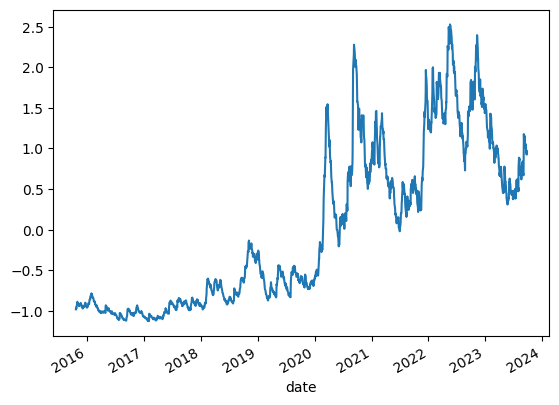

In [72]:
df.xs('AAPL',level=1)['atr'].plot()